
#Training machine learning models on tabular data: an end-to-end example
This tutorial covers the following steps:

*   Visualize the data using Seaborn and matplotlib
*   Run a parallel hyperparameter sweep to train machine learning models on the dataset
*   Explore the results of the hyperparameter sweep with MLflow
*   Register the best performing model in MLflow
*   Apply the registered model to another dataset using a Spark UDF
*   Set up model serving for low-latency requests

In this example, you build a model to predict the quality of Portugese "Vinho Verde" wine based on the wine's physicochemical properties.

The example uses a dataset from the UCI Machine Learning Repository, presented in Modeling wine preferences by data mining from physicochemical properties.

#Requirements
This notebook requires Databricks Runtime for Machine Learning.
If you are using Databricks Runtime 7.3 LTS ML, you must update the CloudPickle library. To do that, uncomment and run the %pip install command in Cmd 2.

In [1]:
!pip install --upgrade mlflow-skinny
!pip install pydantic==1.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere,

#Remember to connect to Google Drive

In [2]:
import pandas as pd

white_wine = pd.read_csv("/content/drive/MyDrive/MLOPS/Tutorial/dataset/winequality-white.csv", sep=";")
red_wine = pd.read_csv("/content/drive/MyDrive/MLOPS/Tutorial/dataset/winequality-red.csv", sep=";")

In [3]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [5]:
red_wine['is_red'] = 1.0
white_wine['is_red'] = 0.0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

print(data.shape)

(6497, 13)


In [6]:
data.head(6000)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,5,0.0
4397,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,5,0.0
4398,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,5,0.0
4399,6.6,0.24,0.22,12.3,0.051,35.0,146.0,0.99676,3.10,0.67,9.4,5,0.0


#Preprocess data
Prior to training a model, check for missing values and split the data into training and validation sets.

In [7]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

#Visualize data
Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

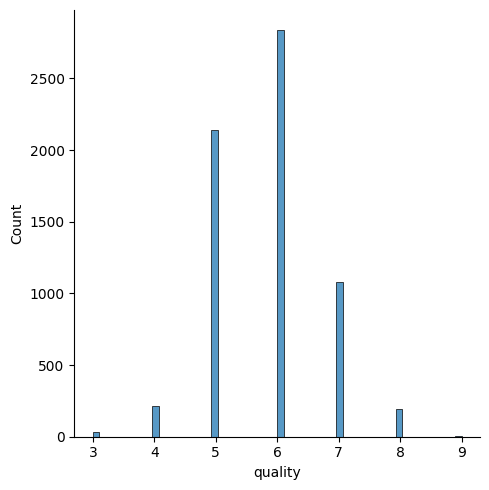

In [8]:
import seaborn as sns

sns.displot(data['quality'], kde=False)

Looks like quality scores are normally distributed between 3 and 9.

**Define a wine as high quality if it has quality >= 7.**

Wines with quality >= 7 will have a label 1, otherwise 0

In [9]:
high_quality = (data["quality"] >= 7).astype(int)
data["quality"] = high_quality
print(data["quality"].shape)

(6497,)


In [10]:
data.head(6000)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,0,0.0
4397,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,0,0.0
4398,7.4,0.27,0.26,11.8,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,0,0.0
4399,6.6,0.24,0.22,12.3,0.051,35.0,146.0,0.99676,3.10,0.67,9.4,0,0.0


Box plots are useful in noticing correlations between features and a binary label.

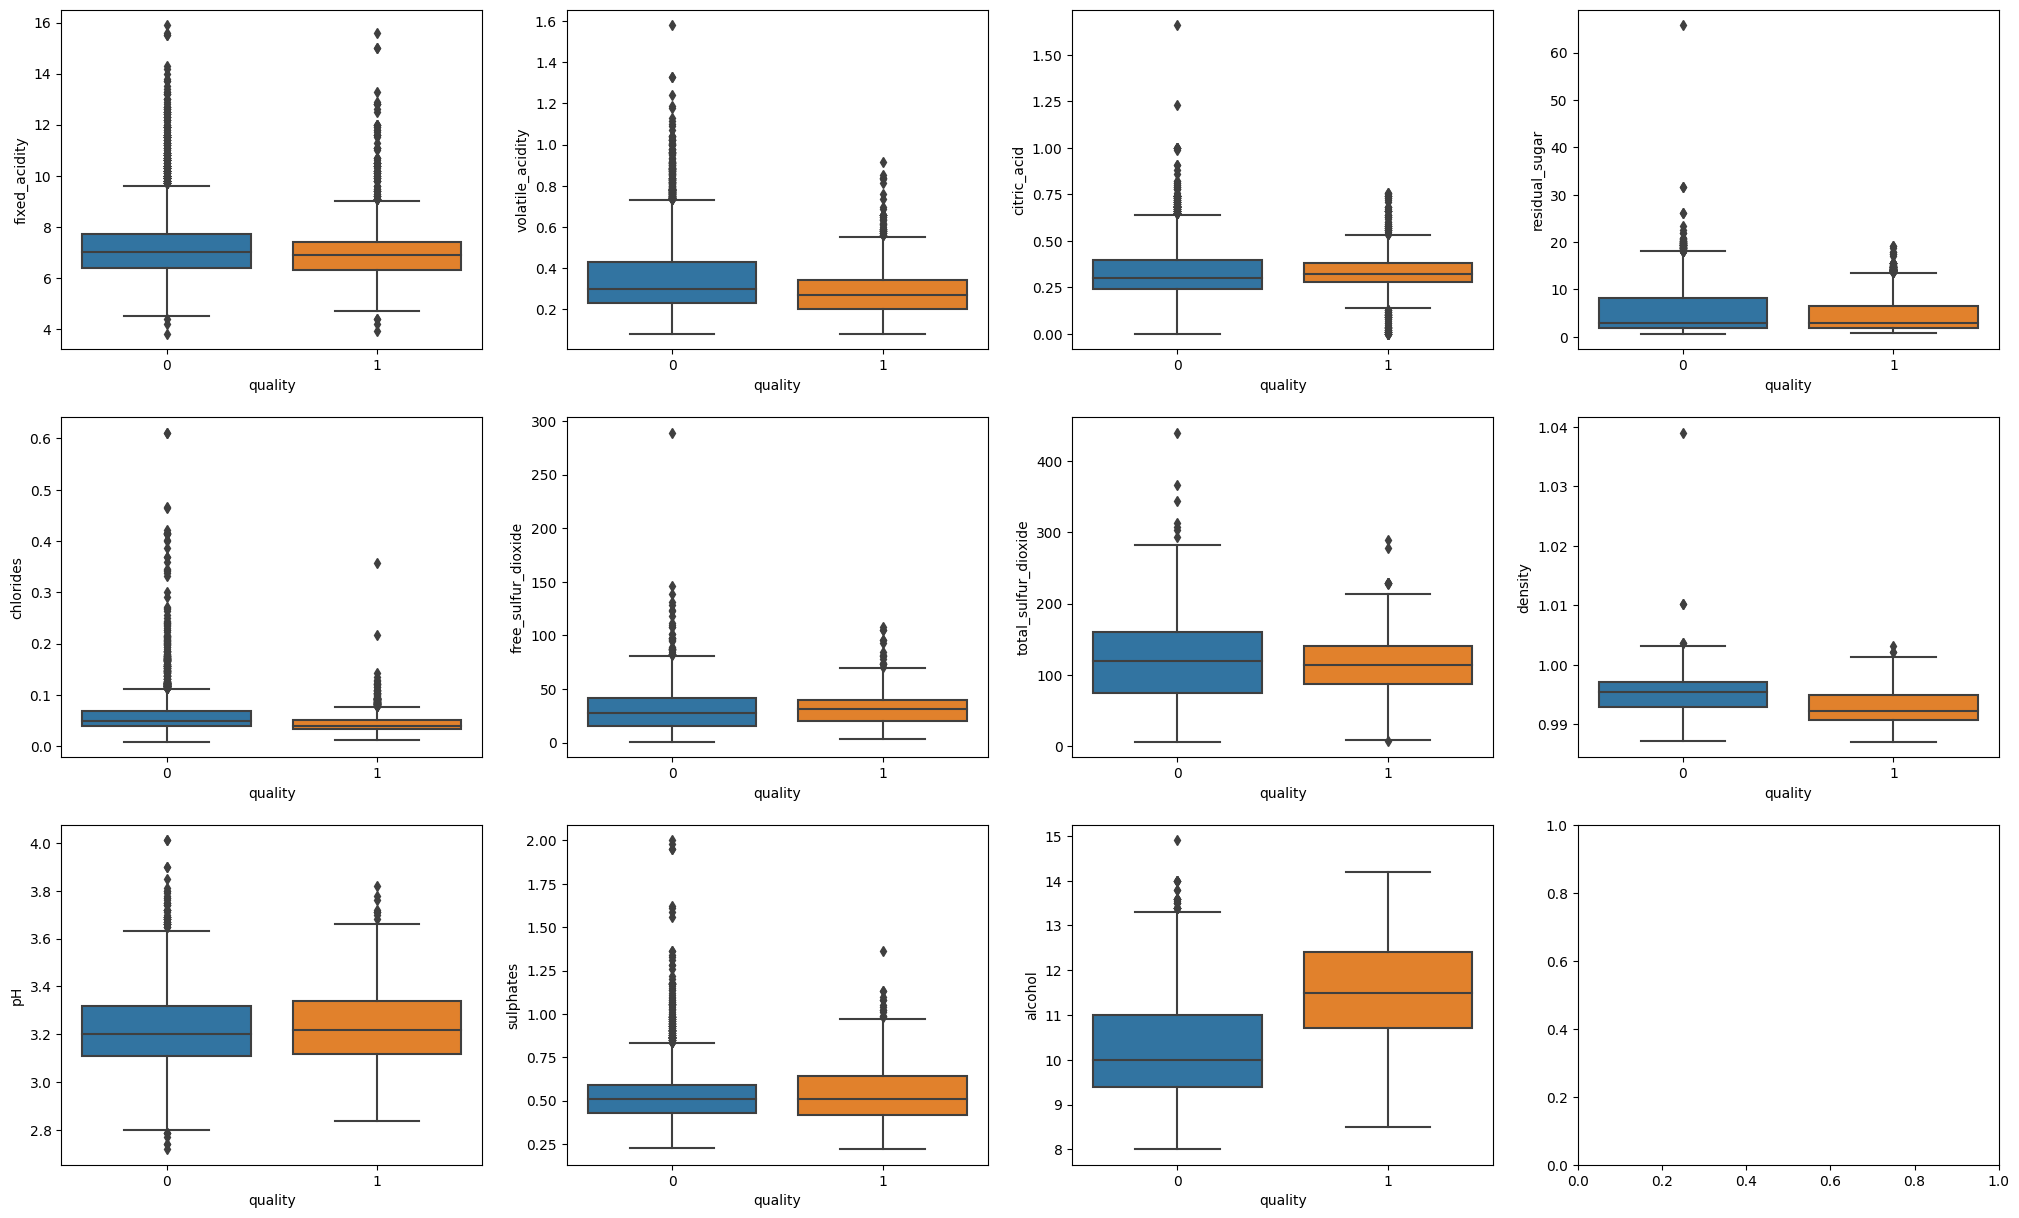

In [11]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

* In the **alcohol** box plot, the median alcohol content of **high quality wines** is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
* In the **density** box plot, **low quality wines** have a greater density than high quality wines. Density is inversely correlated with quality.

#Prepare dataset for training baseline model
Split the input data into 3 sets:

* Train (60% of the dataset used to train the model)
* Validation (20% of the dataset used to tune the hyperparameters)
* Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [12]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data["quality"]

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

print("Train set size: ", X_train.shape)
print("Test set size: ", X_test.shape)
print("Valid set size: ", X_val.shape)

Train set size:  (3898, 12)
Test set size:  (1300, 12)
Valid set size:  (1299, 12)


#Build a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [13]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1).
# The following code creates a wrapper function, SklearnModelWrapper, that uses
# the predict_proba method to return the probability that the observation belongs to each class.

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model

  def predict(self, context, model_input):
    # return probability of quality wine
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model.
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs.
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Examine the learned feature importances output by the model as a sanity-check.

In [14]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


As illustrated by the boxplots shown previously, both **alcohol** and **density** are important in predicting **quality**.

You logged the Area Under the ROC Curve (AUC) to MLflow.

#Register the model in MLflow Model Registry

---


By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI.

In [15]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [16]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model",
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'wine_quality'.
Created version '1' of model 'wine_quality'.


You should now see the model in the Models page.

To display the Models page, click the **File icon** in the left sidebar of Colab.


**mlruns > models > model_name**


Next, transition this model to production and load it into this notebook from Model Registry.

In [17]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

<ModelVersion: aliases=[], creation_timestamp=1699955157341, current_stage='Production', description=None, last_updated_timestamp=1699955172378, name='wine_quality', run_id='5b61a46455314183aa6cb887000485cf', run_link=None, source='file:///content/mlruns/0/5b61a46455314183aa6cb887000485cf/artifacts/random_forest_model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [18]:
import pprint

# Get a list of all registered models
print("List of all registered models")
print("=" * 80)
[print(pprint.pprint(dict(rm), indent=4)) for rm in client.search_registered_models()]

# Get a list of specific versions of the named models
print(f"\nList of Model = {model_name} and Versions")
print("=" * 80)
[pprint.pprint(dict(mv), indent=4) for mv in client.search_model_versions("name='wine_quality'")]

List of all registered models
{   'aliases': {},
    'creation_timestamp': 1699955157338,
    'description': None,
    'last_updated_timestamp': 1699955172378,
    'latest_versions': [   <ModelVersion: aliases=[], creation_timestamp=1699955157341, current_stage='Production', description=None, last_updated_timestamp=1699955172378, name='wine_quality', run_id='5b61a46455314183aa6cb887000485cf', run_link=None, source='file:///content/mlruns/0/5b61a46455314183aa6cb887000485cf/artifacts/random_forest_model', status='READY', status_message=None, tags={}, user_id=None, version=1>],
    'name': 'wine_quality',
    'tags': {}}
None

List of Model = wine_quality and Versions
{   'aliases': [],
    'creation_timestamp': 1699955157341,
    'current_stage': 'Production',
    'description': None,
    'last_updated_timestamp': 1699955172378,
    'name': 'wine_quality',
    'run_id': '5b61a46455314183aa6cb887000485cf',
    'run_link': None,
    'source': 'file:///content/mlruns/0/5b61a46455314183aa6cb

[None]

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

#Use MLflow to view the results

In [19]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8540300975814177


The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better.

# MLflow to track parameters

MLflow tracks the parameters and performance metrics of each run.

In [20]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import numpy as np
import xgboost as xgb

search_space = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': hp.choice('Criterion',['gini', 'entropy', 'log_loss']),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'max_features': hp.choice('max_features',['sqrt', 'log2']),
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 10,
    'n_jobs': None,
    'oob_score': False,
    'random_state': 123,
    'verbose': 1,
    'warm_start': False,
    }

def train_model(params):

  with mlflow.start_run(nested=True, run_name='tunned_random_forest'):
    model = RandomForestClassifier()

    model.set_params(**params)

    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', params['n_estimators'])

    # Use the area under the ROC curve as a metric.
    mlflow.log_metric('auc', auc_score)

    wrappedModel = SklearnModelWrapper(model)

    # Log the model with a signature that defines the schema of the model's inputs and outputs.
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env =  _mlflow_conda_env(
          additional_conda_deps=None,
          additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
          additional_conda_channels=None,
      )
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': model.get_params()}

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "random_forest_models" .

trials = Trials()

with mlflow.start_run(run_name='random_forest_models'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials_save_file="All_Trials_File",
    trials=trials
    )

print("\nBest parameters: ", best_params,"\n")

for items in trials.results:
  print("AUC: ", -1*items["loss"], ", Parameters: ", items["booster"])

100%|██████████| 10/10 [00:01<00:00,  8.42trial/s, best loss: -0.8772973539272031]

Best parameters:  {'Criterion': 1, 'max_depth': 26.0, 'max_features': 0} 

AUC:  0.8540300975814177 , Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 63, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 1, 'warm_start': False}
AUC:  0.8540300975814177 , Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 38, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 1, 'war

#Experiment with a new model
The random forest model performed well.

The following code uses the MLFlow xgboost library to train a more accurate model. As before, the code tracks the performance of each parameter configuration with MLflow.

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 123, # Set a seed for deterministic training
    }

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()

  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)

    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)

    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)

    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}


trials = Trials()

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=trials
  )

run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "xgboost_models"').iloc[0].run_id
model_name = "wine_quality_tunned_xgboost"
model_version = mlflow.register_model(f"runs:/{run_id}/xgboost_model_tunned", model_name)

for items in trials.results:
  print("AUC: ", -1*items["loss"], ", Parameters: ", items["booster"])

[0]	validation-logloss:0.46999
[1]	validation-logloss:0.45099
[2]	validation-logloss:0.43562
[3]	validation-logloss:0.42182
[4]	validation-logloss:0.40908
[5]	validation-logloss:0.39899
[6]	validation-logloss:0.38908
[7]	validation-logloss:0.38181
[8]	validation-logloss:0.37454
[9]	validation-logloss:0.36705
[10]	validation-logloss:0.36163
[11]	validation-logloss:0.35550
[12]	validation-logloss:0.34951
[13]	validation-logloss:0.34582
[14]	validation-logloss:0.34331
[15]	validation-logloss:0.33951
[16]	validation-logloss:0.33576
[17]	validation-logloss:0.33373
[18]	validation-logloss:0.33107
[19]	validation-logloss:0.32888
[20]	validation-logloss:0.32771
[21]	validation-logloss:0.32438
[22]	validation-logloss:0.32332
[23]	validation-logloss:0.32163
[24]	validation-logloss:0.32090
[25]	validation-logloss:0.31921
[26]	validation-logloss:0.31802
[27]	validation-logloss:0.31754
[28]	validation-logloss:0.31654
[29]	validation-logloss:0.31621
[30]	validation-logloss:0.31519
[31]	validation-lo

2023/11/14 09:48:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



[0]	validation-logloss:0.40854
[1]	validation-logloss:0.37946
[2]	validation-logloss:0.36909
[3]	validation-logloss:0.36271
[4]	validation-logloss:0.35329
[5]	validation-logloss:0.35530
[6]	validation-logloss:0.34565
[7]	validation-logloss:0.34067
[8]	validation-logloss:0.34146
[9]	validation-logloss:0.34794
[10]	validation-logloss:0.35071
[11]	validation-logloss:0.35609
[12]	validation-logloss:0.35325
[13]	validation-logloss:0.35639
[14]	validation-logloss:0.35502
[15]	validation-logloss:0.35532
[16]	validation-logloss:0.35866
[17]	validation-logloss:0.36057
[18]	validation-logloss:0.36031
[19]	validation-logloss:0.36308
[20]	validation-logloss:0.36357
[21]	validation-logloss:0.36718
[22]	validation-logloss:0.36759
[23]	validation-logloss:0.36847
[24]	validation-logloss:0.36999
[25]	validation-logloss:0.37065
[26]	validation-logloss:0.37200
[27]	validation-logloss:0.37259
[28]	validation-logloss:0.37287
[29]	validation-logloss:0.37614
[30]	validation-logloss:0.37703
[31]	validation-lo

2023/11/14 09:48:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



[0]	validation-logloss:0.42689
[1]	validation-logloss:0.39588
[2]	validation-logloss:0.37659
[3]	validation-logloss:0.36421
[4]	validation-logloss:0.35816
[5]	validation-logloss:0.35300
[6]	validation-logloss:0.34886
[7]	validation-logloss:0.34694
[8]	validation-logloss:0.34450
[9]	validation-logloss:0.34361
[10]	validation-logloss:0.34429
[11]	validation-logloss:0.34365
[12]	validation-logloss:0.34591
[13]	validation-logloss:0.34712
[14]	validation-logloss:0.34660
[15]	validation-logloss:0.34842
[16]	validation-logloss:0.34918
[17]	validation-logloss:0.34875
[18]	validation-logloss:0.35052
[19]	validation-logloss:0.34968
[20]	validation-logloss:0.34671
[21]	validation-logloss:0.34702
[22]	validation-logloss:0.34639
[23]	validation-logloss:0.34756
[24]	validation-logloss:0.34636
[25]	validation-logloss:0.34638
[26]	validation-logloss:0.34484
[27]	validation-logloss:0.34442
[28]	validation-logloss:0.34593
[29]	validation-logloss:0.34538
[30]	validation-logloss:0.34528
[31]	validation-lo

2023/11/14 09:48:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



[0]	validation-logloss:0.43394
[1]	validation-logloss:0.39786
[2]	validation-logloss:0.37611
[3]	validation-logloss:0.35909
[4]	validation-logloss:0.34760
[5]	validation-logloss:0.34045
[6]	validation-logloss:0.33482
[7]	validation-logloss:0.33231
[8]	validation-logloss:0.33387
[9]	validation-logloss:0.33437
[10]	validation-logloss:0.33619
[11]	validation-logloss:0.33651
[12]	validation-logloss:0.33728
[13]	validation-logloss:0.33583
[14]	validation-logloss:0.33929
[15]	validation-logloss:0.33873
[16]	validation-logloss:0.33939
[17]	validation-logloss:0.34202
[18]	validation-logloss:0.34590
[19]	validation-logloss:0.34731
[20]	validation-logloss:0.34730
[21]	validation-logloss:0.34955
[22]	validation-logloss:0.35014
[23]	validation-logloss:0.35291
[24]	validation-logloss:0.35531
[25]	validation-logloss:0.35565
[26]	validation-logloss:0.35626
[27]	validation-logloss:0.35917
[28]	validation-logloss:0.36087
[29]	validation-logloss:0.36257
[30]	validation-logloss:0.36156
[31]	validation-lo

2023/11/14 09:48:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:48:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



[0]	validation-logloss:0.40800
[1]	validation-logloss:0.37794
[2]	validation-logloss:0.36293
[3]	validation-logloss:0.34741
[4]	validation-logloss:0.34453
[5]	validation-logloss:0.34526
[6]	validation-logloss:0.34050
[7]	validation-logloss:0.33672
[8]	validation-logloss:0.34085
[9]	validation-logloss:0.34109
[10]	validation-logloss:0.34027
[11]	validation-logloss:0.33921
[12]	validation-logloss:0.34046
[13]	validation-logloss:0.34329
[14]	validation-logloss:0.34514
[15]	validation-logloss:0.34687
[16]	validation-logloss:0.34789
[17]	validation-logloss:0.35035
[18]	validation-logloss:0.34813
[19]	validation-logloss:0.34913
[20]	validation-logloss:0.35109
[21]	validation-logloss:0.35002
[22]	validation-logloss:0.35097
[23]	validation-logloss:0.35196
[24]	validation-logloss:0.35194
[25]	validation-logloss:0.35212
[26]	validation-logloss:0.35286
[27]	validation-logloss:0.35134
[28]	validation-logloss:0.35348
[29]	validation-logloss:0.35191
[30]	validation-logloss:0.35487
[31]	validation-lo

2023/11/14 09:49:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:49:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:49:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



100%|██████████| 5/5 [00:40<00:00,  8.15s/trial, best loss: -0.894325056572405]
AUC:  0.894325056572405 , Parameters:  {'best_iteration': '51', 'best_score': '0.3091637848132936'}
AUC:  0.8801511676236511 , Parameters:  {'best_iteration': '7', 'best_score': '0.34066591411595987'}
AUC:  0.8764143101245362 , Parameters:  {'best_iteration': '44', 'best_score': '0.33847984225968036'}
AUC:  0.888790966887825 , Parameters:  {'best_iteration': '7', 'best_score': '0.3323055212791031'}
AUC:  0.8722387278520958 , Parameters:  {'best_iteration': '7', 'best_score': '0.33672308586620286'}


Registered model 'wine_quality_tunned_xgboost' already exists. Creating a new version of this model...
Created version '3' of model 'wine_quality_tunned_xgboost'.
